In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import shap

## 1. Read data

In [177]:
df = pd.read_excel('./default_of_credit_card_clients.xls',sep = '\t') # read the excel file
df = df.drop('ID', axis = 1)   # drop the ID column 

# convert the long string name 'default payment next month' to 'Default_y' for convenience 
df = df.rename(columns = {'default payment next month': 'Default_y'})

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default_y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
Default_y    30000 non-null int64
dtypes: int64(24)
memory usage: 5.5 MB


Let's check the attribute information first! 

This datset contains a binary variable, default.payment.next.month (Yes = 1, No = 0) as the response variable and the following 23 variables as explanatory variables. I change the name of response variable  as 'Default_y'for convenience. The dimension size of this dataset is 30000(rows) by 24 (columns). The original UCI dataset shows variables from X1 to X23 but I apply the real definiation of each variable as the column names showing below:

* ID: ID of each client and will be dropped.
* LIMIT_BAL: Amount of given credit in NT dollars (includes both individual and family/supplementary credit)
* SEX: Gender (1 = male, 2 = female)
* EDUCATION: (1 = graduate school, 2 = university, 3 = high school, 4 = others)
* MARRIAGE: Marital status (1 = married, 2 = single, 3 = others)
* AGE: Age (year)

History of past payment: (from April to September, 2005)
scales: -1=pay duly , 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above
* PAY_0: Repayment status in September, 2005 
* PAY_2: Repayment status in August, 2005 
* PAY_3: Repayment status in July, 2005 
* PAY_4: Repayment status in June, 2005 
* PAY_5: Repayment status in May, 2005 
* PAY_6: Repayment status in April, 2005 

Amount of bill statement (NT dollar):
* BILL_AMT1: Amount of bill statement in September, 2005 
* BILL_AMT2: Amount of bill statement in August, 2005 
* BILL_AMT3: Amount of bill statement in July, 2005 
* BILL_AMT4: Amount of bill statement in June, 2005 
* BILL_AMT5: Amount of bill statement in May, 2005 
* BILL_AMT6: Amount of bill statement in April, 2005 

Amount of previous payment(NT dollar):
* PAY_AMT1: Amount of previous payment in September, 2005 
* PAY_AMT2: Amount of previous payment in August, 2005 
* PAY_AMT3: Amount of previous payment in July, 2005 
* PAY_AMT4: Amount of previous payment in June, 2005 
* PAY_AMT5: Amount of previous payment in May, 2005 
* PAY_AMT6: Amount of previous payment in April, 2005 

## 2. Exploratory data analysis (EDA)

### 2.1 Check missing value 

In [178]:
# check missing values 
df.isna().sum() 

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Default_y    0
dtype: int64

Notes:
* There is no missing value in the dataset. Then I check the distribution of each variable to see if there exists anomalous data. I classify all the features into categorical and numerical ones.

### 2.2  Categorical features 
* There are three categorical variables in the dataset, including SEX, MARRIAGE, and EDUCATION

Text(0.5, 0, 'EDUCATION')

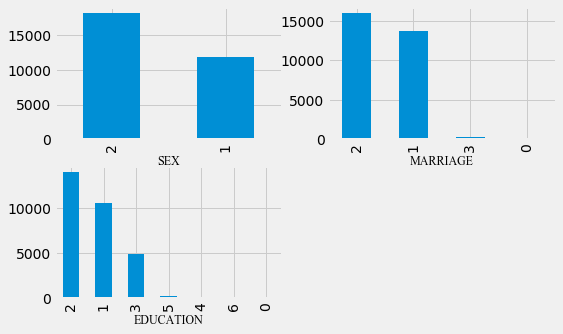

In [188]:
#plot distribution of each categorical variable
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 12}

plt.figure(figsize=(8,5))

plt.subplot(2, 2, 1)
df.SEX.value_counts().plot(kind = 'bar')
plt.xlabel("SEX",font)


plt.subplot(2, 2, 2)
df.MARRIAGE.value_counts().plot(kind = 'bar')
plt.xlabel("MARRIAGE",font)

plt.subplot(2, 2, 3)
df.EDUCATION.value_counts().plot(kind = 'bar')
plt.xlabel("EDUCATION",font)


UCI infomation shows here:
* SEX: Gender (1 = male, 2 = female)
* EDUCATION: (1 = graduate school, 2 = university, 3 = high school, 4 = others)
* MARRIAGE: Marital status (1 = married, 2 = single, 3 = others)

* From the descriptions and plots above, I find Marriage and Education occurr values lack definition, such as some undocumented labels (MARRIAGE = 0, EDUCATION = 0) and some unknown labels (EDUCATION = 5, EDUCATION = 6).  I will deal with this isuue in the next step in data cleaning. 

### 2.2  Numerical features 
* There are 20 numerical features,which can be grouped into five groups. I will check the distribution of each of them.

### 2.2.1 LIMIT_BAL: Amount of given credit in NT dollars (1 feature)

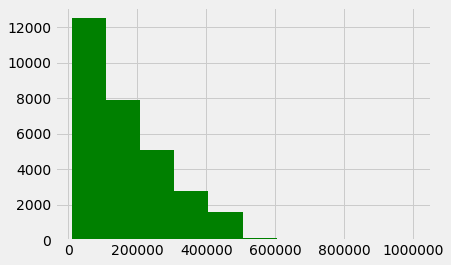

In [170]:
df.LIMIT_BAL.hist(color="green")

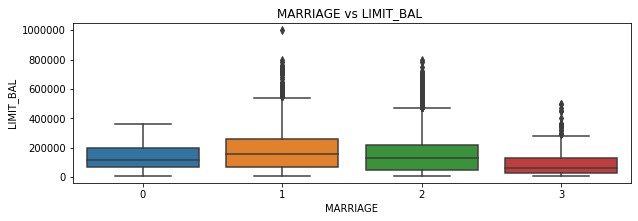

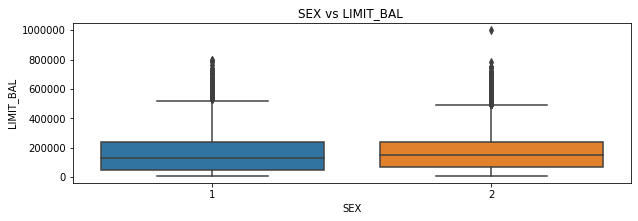

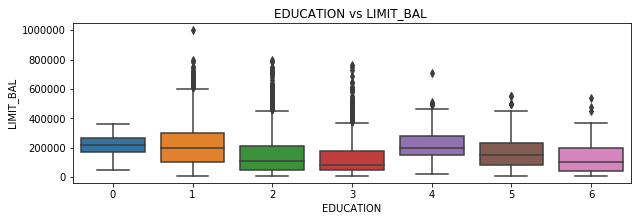

In [9]:
# check relation between LIMIT_BAL and 'MARRIAGE', 'SEX', and 'EDUCATION'
a = 1
for i in ['MARRIAGE', 'SEX', 'EDUCATION']:
    plt.figure(figsize=(10,10))
    plt.subplot(3,1,a)
    sns.boxplot(data=df, y='LIMIT_BAL', x=i)
    plt.title(i + ' vs LIMIT_BAL ')
plt.show()

Notes:
* MARRIGE: married customers (1 = married) have average higher credit limit
* Gender is less likely to effect much on credit limit
* Customers with graduate education (graduate school= 1) and OTHERS (4) class have higher credit limit on average.

### 2.2.2 AGE:  year (1 feature)

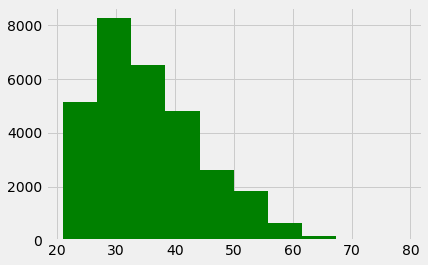

In [171]:
df.AGE.hist(color="green")

### 2.2.3 Repayment status (6 feature)
* Features:'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
* Scale: -1=pay duly , 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above

In [151]:
df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [10]:
# I define a funtion here to plot a series of histograms 
def histograms(df, vars, nrows, ncols, nbins):
    fig = plt.figure()
    for i, name in enumerate(vars):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        df[name].hist(bins = nbins, ax = ax)
        ax.set_title(name)
    fig.tight_layout()
    plt.show()

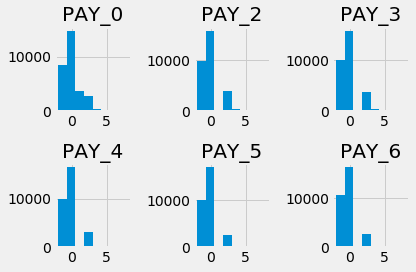

In [174]:
pay = df[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
histograms(pay, pay.columns, 2, 3, 8)

Notes:
* From PAY_0 to PAY_6, I find another an undocumented label '-2' and '0' in repayment status. 
* According to UCI, 1, 2, 3, ..., 8 are the months of delay, and -1 indicates 'pay duly'. It could be reseasonal to assume '0' and '-2' as "pay duly". I will deal with this issue in the data cleaning part.

### 2.2.4 Amount of bill statement (6 feature) 
* Features:'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'
* Scale: NT dollar

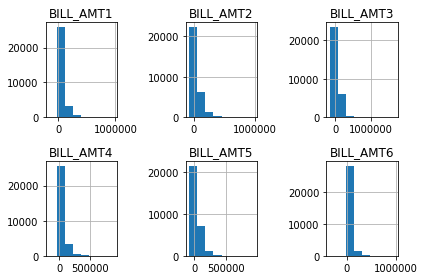

In [159]:
bills = df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
histograms(bills, bills.columns, 2, 3, 8)

### 2.2.5 Amount of previous payment (6 feature) 
* Features: 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
* Scale: NT dollar

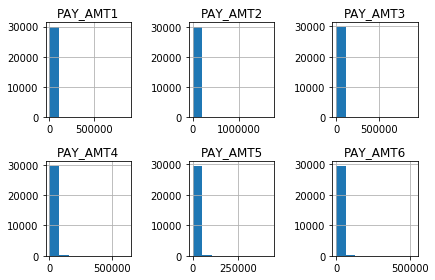

In [170]:
pay_amt = df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

histograms(pay_amt, pay_amt.columns, 2, 3, 8)

*  All these 20 plots show that all the numerical variables are skewed distributed.

### 2.3 Default_y

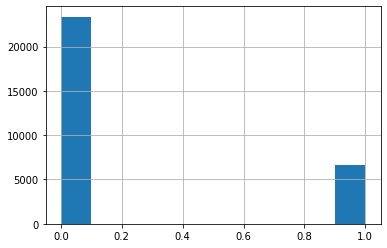

In [174]:
df.Default_y.hist()

Notes:
* This dataset has more samples for 'No default' group (Default_y == 0), which means it is an unbalanced dataset. 
* I will choose ML models which can handle unbalanced dataset in the modeling part.

## 3. Data cleaning 
* As I menthioned before, I find Marriage and Education occurr values lack definition and undocumented label in Repayment status. I will clean these parts before model training.

### 3.1 Marriage and Education
* I will categorized these undocumented labels (MARRIAGE = 0, EDUCATION = 0) and unknown labels (EDUCATION = 5, EDUCATION = 6) as "others" group because of the following reasons: 
* * (1) sample size of each undocumented/unknown label is small and then I can group them
* * (2) It is chanllenging to use some other models to interprete these undocumented or unknown labels 

In [161]:
# group undocumented labels in MARRIAGE to group 3
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

# group undocumented labels in EDUCATION to group 4
edu_un = (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0)
df.loc[edu_un, 'EDUCATION'] = 4

Text(0.5, 0, 'EDUCATION')

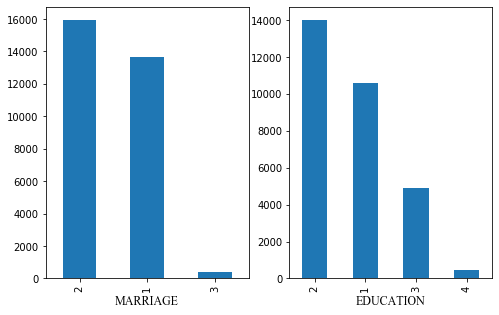

In [166]:
#plot distribution of updated "MARRIAGE" and "EDUCATION"
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
df.MARRIAGE.value_counts().plot(kind = 'bar')
plt.xlabel("MARRIAGE", font)

plt.subplot(1, 2, 2)
df.EDUCATION.value_counts().plot(kind = 'bar')
plt.xlabel("EDUCATION", font)

### 3.2 Repayment status 
* From PAY_0 to PAY_6, I find another an undocumented label '-2' and '0' in repayment status. It is reasonable to label 0 and -2 "pay duly".
* To make it more understandable, I combine 'PAY = -2, -1' to 'PAY = 0', which means there is no delay time.

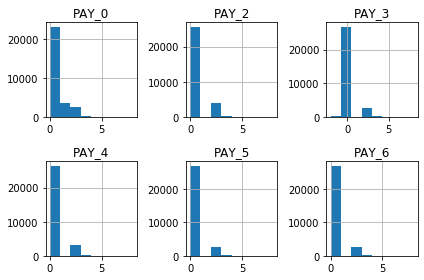

In [171]:
un = (df.PAY_0 == -2) | (df.PAY_0 == -1) | (df.PAY_0 == 0)
df.loc[un, 'PAY_0'] = 0
un = (df.PAY_2 == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0)
df.loc[un, 'PAY_2'] = 0
fil = (df.PAY_3 == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0)
df.loc[un, 'PAY_3'] = 0
un = (df.PAY_4 == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0)
df.loc[un, 'PAY_4'] = 0
un = (df.PAY_5 == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0)
df.loc[un, 'PAY_5'] = 0
un = (df.PAY_6 == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0)
df.loc[un, 'PAY_6'] = 0

pay = df[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
histograms(pay, pay.columns, 2, 3, 8)

## 4. Feature Engineering
* In this part, I will check correlation of all the features.

### 4.1 Correlation check 

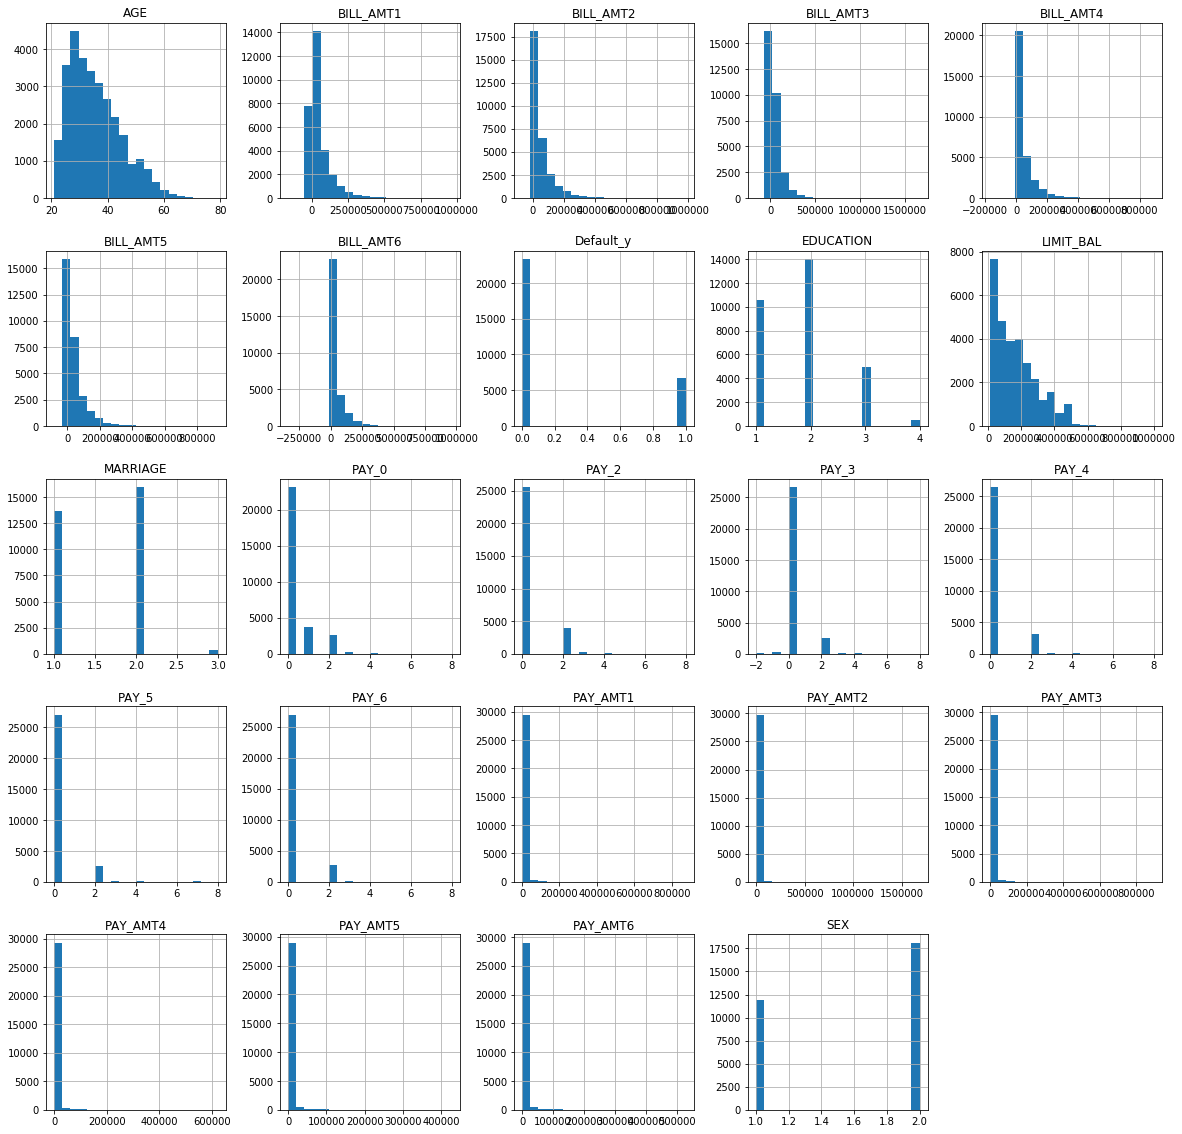

In [172]:
# plot all the features after data cleaning 
df.hist(figsize=(20,20), bins=20);

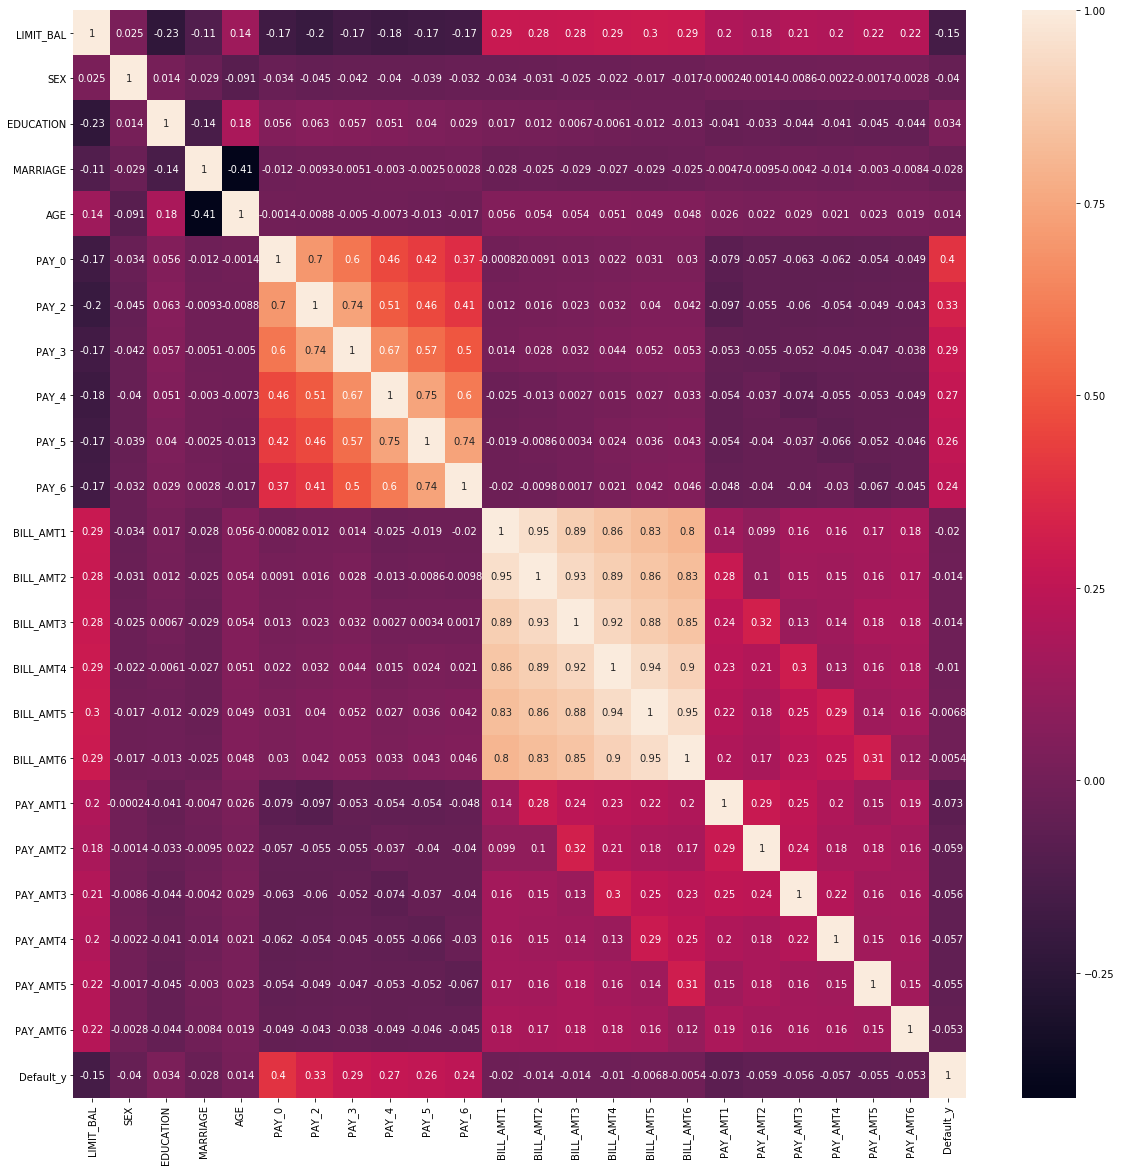

In [175]:
# plot the correlation matrix. It only show linear relationships here. 
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True);

Notes:
* BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, & BILL_AMT6 are strongly correlated
* PAY_0, PAY_2, PAY_3, PAY_4, PAY_5 & PAY_6 are highly correlated
* There is a slight negatitive correlation between PAY_ and PAY_AMT (all columns)
* There is negatitive correlation of LIMIT_BAL with PAY_0, PAY_2, PAY_3, PAY_4, PAY_5 & PAY_6

## 5. Model training and evaluation 
In this part, I will first split the dataset into training and test dataset.
Then I will test two tree-based ML models, which are Random Forest and XGboosting. The reasons why I test these two models are listed below.
* (1)  perform well on imbalanced datasets
* (2)  do automatic feature selections during training 

I will train the model with initial parameters and then apply 'RandomizedSearchCV' and 'GridSearchCV' to find the best parameters for both models.

Regarding model evaluation, I will check the confusion matrix, F1 score and AUC (ROC curves) rather than only accuracy. Becasue it is not robust to use accuracy as the evaluation matrix for unbalanced dataset.

### 5.1 One hot encoding for catergorical features
* Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. I will use One-hot encoding here.

In [13]:
# one hot encoding for 'SEX', 'MARRIAGE' & 'EDUCATION'
X = pd.get_dummies(data=df, columns=['SEX', 'MARRIAGE', 'EDUCATION'])
X.drop(columns=['Default_y'], axis=1, inplace=True)

#creating response values
y = df['Default_y']

X.head(5)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,1,0,0,0,0,1,0,0,0,0
1,120000,26,-1,2,0,0,0,2,2682,1725,...,0,1,0,0,0,1,0,0,0,0
2,90000,34,0,0,0,0,0,0,29239,14027,...,0,1,0,0,0,1,0,0,0,0
3,50000,37,0,0,0,0,0,0,46990,48233,...,1,0,0,0,0,1,0,0,0,0
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,1,0,0,0,0,1,0,0,0,0


### 5.2 Split the dataset

In [14]:
# split the dataset into training(75%) and test(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
print("Variables in Train Set : {} & Test Set : {}".format(len(X_train), len(X_test)))

Variables in Train Set : 22500 & Test Set : 7500


### 5.3 Random Forest model 

In [72]:
# Create random forest with initial parameters.
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [115]:
# set up parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 35, 60, 85, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [116]:
# Use the random grid to search for best hyperparameters
rf_random = RandomizedSearchCV(estimator = model_rf, 
                               param_distributions = random_grid, 
                               n_iter = 100,  
                               cv = 3,          
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1
                              )
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100,
                                                    n_jobs=None,
 

In [117]:
# check the best parameters
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

In [128]:
# Create random forest with updated parameters.
model_rf1 = RandomForestClassifier(bootstrap=True, 
                                   class_weight=None, 
                                   max_depth=110, 
                                   max_features='auto', 
                                   min_samples_leaf=2, 
                                   min_samples_split=10,
                                   n_estimators=500
                                  )

model_rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=110, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [129]:
y_pred1 = model_rf1.predict(X_test)

In [130]:
# Testing Set Performance
cm = confusion_matrix(y_test, y_pred1)
roc_auc = roc_auc_score(y_test, y_pred1)
print("Classification Report :- \n",classification_report(y_test, y_pred))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      5918
           1       0.65      0.36      0.47      1582

    accuracy                           0.83      7500
   macro avg       0.75      0.66      0.68      7500
weighted avg       0.81      0.83      0.80      7500

ROC AUC: 0.6553686304484081
Confusion Matrix:
[[5591  327]
 [1003  579]]


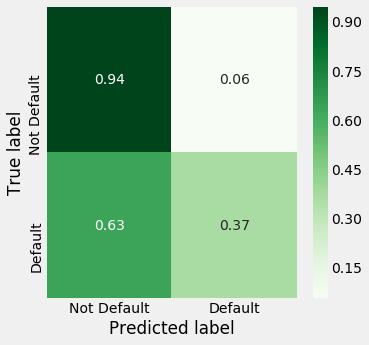

In [131]:
confusion_matrix_xg = confusion_matrix(y_test, y_pred1)
# Turn matrix to percentages
confusion_matrix_xg = confusion_matrix_xg.astype('float') / confusion_matrix_xg.sum(axis = 1)[:, np.newaxis]
 
# Turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_xg, index = ['Not Default', 'Default'], columns = ['Not Default', 'Default'])
 
# Parameters of the image
figsize = (5,5)
fontsize = 10
 
# Create image
fig = plt.figure(figsize = figsize)
heatmap = sns.heatmap(df_cm, annot = True, fmt = '.2f',linecolor = "Darkblue", cmap = "Greens",
            yticklabels = ['Not Default', 'Default'],)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Notes:
* Random forest model has more prediction power for 'Not Default' group with high F1-score(0.90). However, 'Default' group has low F1-score and low recall. For the debit/credit card products(such as credit seasme card), We more care about the classification power of 'Default' group. So I will test XGboosting model and check whether performance will increase.

### 5.4 XGboosting model 

I will try a simple XGboosting model first.

In [83]:
# Generate simple XGboosting model with initial parameters.
model_xg = xgb.XGBClassifier(objective='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)
model_xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:squarederror', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [84]:
y_pred = model_xg.predict(X_test)

In [85]:
# Testing Set Performance
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("Classification Report :- \n",classification_report(y_test, y_pred))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      5918
           1       0.65      0.36      0.47      1582

    accuracy                           0.83      7500
   macro avg       0.75      0.66      0.68      7500
weighted avg       0.81      0.83      0.80      7500

ROC AUC: 0.6552684411354674
Confusion Matrix:
[[5616  302]
 [1010  572]]


The result shows simple model has more prediction for 'Not Default' group with high F1-score. However, 'Default' group has low F1-score and low recall. So I choose the best hyperparameters by Grid Search to improve model performance.

In [89]:
# Define the parameters
param_grid = dict({'n_estimators': [100, 150, 200],
                   'max_depth': [2, 3, 4],
                 'learning_rate' : [0.01, 0.05, 0.1, 0.15]
                  })

In [91]:
# Define grid search object.
GridXGB = GridSearchCV(model_xg1,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 10,              # Number of cross-validation folds.  
                       scoring = 'recall', # How to rank outputs.
                       n_jobs = 8,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [93]:
GridXGB.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  7.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=10,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=1, reg_lambda=0,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=8,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100,

In [94]:
# check the best parameters
print(GridXGB.best_params_.get('max_depth'))
print (GridXGB.best_params_.get('learning_rate'))
print(GridXGB.best_params_.get('n_estimators'))

4
0.1
200


In [132]:
# Create XGB with updated parameters.
model_xg1 = xgb.XGBClassifier(max_depth = 4,                # Depth of each tree (This should be between 3-10)
                            learning_rate = 0.1,            # How much to shrink error in each subsequent training
                            n_estimators = 200,             # How many trees to use
                            objective = 'binary:logistic',  # Type of target variable.
                            booster = 'gbtree',             # boost Trees 
                            n_jobs = 8,                     # Parallel jobs to run.
                            gamma = 0.01,                   # A smaller value like 0.01-0.02 can also be chosen for starting (Minimum loss reduction required for partition on a leaf node.
                            subsample = 0.75,               # Subsample ratio. Typical values range between 0.5-0.9
                            colsample_bytree = 0.8,         # Subsample ratio of columns when constructing each tree.Typical values range between 0.5-0.9
                            colsample_bylevel = 1,          # Subsample ratio of columns when constructing each level. 
                            colsample_bynode = 1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha = 1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda = 0,                 # Regularizer for first fit.
                            scale_pos_weight = 3,           # Balancing of positive and negative weights.
                            base_score = 0.5,               # Global bias. Set to average of the target rate.
                            random_state = 0,               # Seed
                            missing = None                 
                            )

In [133]:
model_xg1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=0, scale_pos_weight=3, seed=None,
              silent=None, subsample=0.75, verbosity=1)

In [134]:
y_pred1 = model_xg1.predict(X_test)

In [135]:
# Testing Set Performance
cm = confusion_matrix(y_test, y_pred1)
roc_auc = roc_auc_score(y_test, y_pred1)
print("Classification Report :- \n",classification_report(y_test, y_pred1))
print('ROC AUC: {}'.format(roc_auc))
print('Confusion Matrix:\n{}'.format(cm))

Classification Report :- 
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      5918
           1       0.48      0.61      0.54      1582

    accuracy                           0.78      7500
   macro avg       0.68      0.72      0.70      7500
weighted avg       0.80      0.78      0.79      7500

ROC AUC: 0.7179460421803416
Confusion Matrix:
[[4869 1049]
 [ 612  970]]


* The model performance improves a lot after hyperparameters tunning.

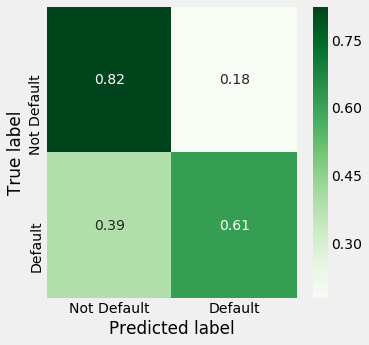

In [136]:
confusion_matrix_xg = confusion_matrix(y_test, y_pred1)
# Turn matrix to percentages
confusion_matrix_xg = confusion_matrix_xg.astype('float') / confusion_matrix_xg.sum(axis = 1)[:, np.newaxis]
 
# Turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_xg, index = ['Not Default', 'Default'], columns = ['Not Default', 'Default'])
 
# Parameters of the image
figsize = (5,5)
fontsize = 10
 
# Create image
fig = plt.figure(figsize = figsize)
heatmap = sns.heatmap(df_cm, annot = True, fmt = '.2f',linecolor = "Darkblue", cmap = "Greens",
            yticklabels = ['Not Default', 'Default'],)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Feature importance 
* I will use two methods to check features importance, which are Xgboost Built-in and SHAP Values(average impact of model outputs).

Text(0.5, 0, 'Xgboost Feature Importance')

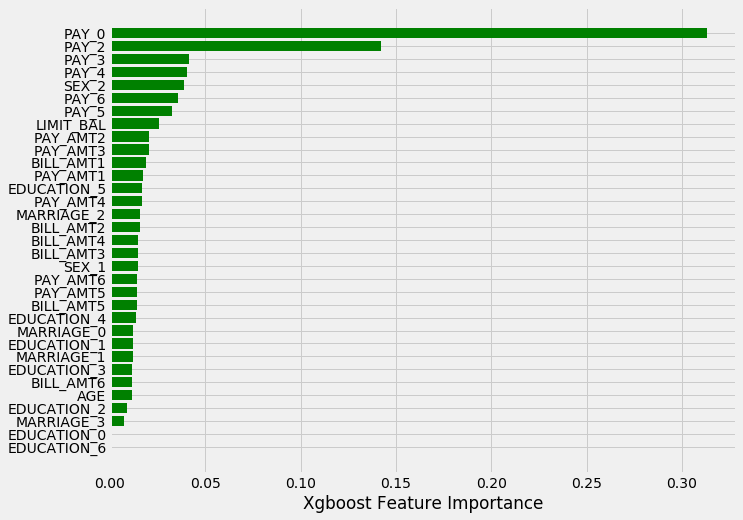

In [158]:
#1. Xgboost Built-in Feature Importance
fig, (ax) = plt.subplots(ncols=1, figsize=(10,8))
sorted_idx = model_xg1.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], model_xg1.feature_importances_[sorted_idx], color="green")
plt.xlabel("Xgboost Feature Importance")

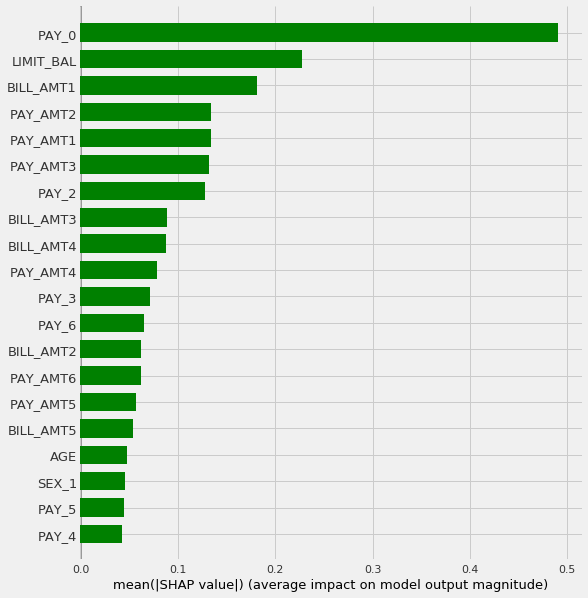

In [159]:
#2. Feature Importance Computed with SHAP Values
explainer = shap.TreeExplainer(model_xg1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", color="green")

Summary:
*  Comparison of model outputs
* Random forest model: ROC AUC: 0.658        
               precision    recall  f1-score   support
           0       0.85      0.95      0.90      5918
           1       0.65      0.36      0.47      1582
           
* XGboosting model: ROC AUC: 0.718      
               precision    recall  f1-score   support
           0       0.89      0.82      0.85      5918
           1       0.48      0.61      0.54      1582


*  Random forest and XGboosting model perform well for 'no default' group with high F1 score.
*  Both models have relatively low F1 score for 'Default' group.  It is likely caused by unbalanced dataset issue that there are more samples in 'no Default' group.
*  XGboosting model performs better than random forest model base on confusion matrix, F1 and AUC score to predict 'Default' group.


* PAY_0,BILL_AMT1, PAY_AMT1, and LIMIT_BAL, are considered as most important features from two features importance methods.

* Cross validation and hyperparameters tunning for both models can actually improve model performance.
* If I have more time, I will try to apply SMOTE(synthesize new examples from the minority class) to balance the dataste, which should help improve model prediction power.

* Credit default can be defined as the failure to repay a debt including interest or principal on a loan or security on the due date. A default can occur when a borrower is unable to make timely payments, misses payments, or avoids or stops making payments. It can cause losses for lenders. By applying XGboosting model, it can help lenders(such as Sesame Cash debit card) with early detection for potential default.
